In [3]:
%pylab inline
import numpy as np
import scipy as sp
from matplotlib.pyplot import imread, quiver, quiverkey
from scipy.ndimage import gaussian_filter, maximum_filter, minimum_filter, sobel, gaussian_filter1d

Populating the interactive namespace from numpy and matplotlib


### images

In [82]:
notre_dame = imread('data/Notre Dame/1_o.jpg')

### Visualizators

In [163]:
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return x, y

def plot_quiver(hist, bins, scale=1, n=None):
    if n is None:
        n = len(hist)
    x, y = pol2cart(hist, bins)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.quiver(np.zeros(n), np.zeros(n), x[:n], y[:n], units='xy', scale=scale)
    plt.axis('equal')
    plt.xticks(range(-5,6))
    plt.yticks(range(-5,6))
    

### globals

In [ ]:
PATCH_R = 20
PAD_SIZE = PATCH_R*2 + 1
BIN_N = 36
BIN_SIZE = 360/BIN_N
DOMINANT_ANGLE_PEAK_TRESHOLD = 0.9

### Image preprocesing functions

In [101]:
def rgb2y(img):
    return img.dot(np.array([ 0.2989,  0.5866,  0.1145]))

def normalize(img):
    return img / img.max()

def extract_patch(img, pos, angle=0, scale=1, R=PATCH_R):
    x, y = int(pos[0]), int(pos[1])
    sl = (slice(y-R, y+R+1), slice(x-R, x+R+1))
    return img[sl]

### Kernel generators

In [103]:
def kernel_gen(sigma, R):
    def kernel(data):
        data -= R
        dist = (data**2).sum(axis=1)
        return np.exp(-(dist)/(2 * (sigma**2)))
    return kernel

def img_gen(function, target_shape=None):
    if target_shape is None:
        target_shape = source_image.shape
    cx, cy = np.meshgrid(np.arange(target_shape[0]), np.arange(target_shape[1]))
    coords = np.stack((cx,cy), axis=2).reshape((-1,2), order='F')
    pts = function(np.fliplr(coords))
    assert coords.shape[0] == pts.shape[0], ("Original coords shape %s is not mathching samples shape %s." % (coords.shape, pts.shape))
    tshape = (target_shape[1], target_shape[0], target_shape[2])
    pts = pts.reshape(tshape, order='F').transpose((1,0,2))
    return pts.copy()

def gaussian_kernel(sigma):
    return img_gen(kernel_gen(sigma, PATCH_R), (PATCH_R*2+1,PATCH_R*2+1,1))[:,:,0]

# Task 1 - Compute dominant orientation of features

In [190]:
def dominant_orientation(image, cgrad, gradangle, feature):    
    descrips = []
    x, y, scale = feature
    
    patch = extract_patch(image, [x,y])
    patch_cgrad = extract_patch(cgrad, [x,y])
    patch_gradangle = extract_patch(gradangle, [x,y])

    weights = gaussian_kernel(scale * 1.5) * np.abs(patch_cgrad)

    # Compute histogram
    _range = (-180 - BIN_SIZE/2, 180 + BIN_SIZE/2)
    hist, bins = np.histogram(a=patch_gradangle, bins=BIN_N + 1, range=_range, weights=weights, density=False)
    # sum the same ranges: 175:185, -185:-175
    hist[0] += hist[-1]
    hist = hist[0:BIN_N]
    hist_s = np.argsort(hist)
    bins += BIN_SIZE/2

    bins = bins[hist_s][::-1]
    hist = hist[hist_s][::-1]
    return hist, bins

def compute_features_dominant_orientation(image, features):
    # Convert image to intensity and normalize to [0, 1]
    I = normalize(rgb2y(image))

    # Add padding around I
    I = np.pad(I, ((PAD_SIZE,PAD_SIZE),(PAD_SIZE,PAD_SIZE)), mode='edge')
    features += np.array([PAD_SIZE, PAD_SIZE, 0])
    
    # Y is inverted, because the Y axis direction in complex space is different than in image space
    gradient_kernel = [-1.0, 0.0, 1.0]
    dY =  sp.ndimage.convolve1d(I, gradient_kernel, axis=0)
    dX = -sp.ndimage.convolve1d(I, gradient_kernel, axis=1)
    # magnitude
    cgrad = dX + 1j * dY
    # angle
    gradangle = np.angle(cgrad, deg=True)
    
    return [dominant_orientation(image=I, cgrad=cgrad, gradangle=gradangle, feature=f) for f in features]

In [191]:
r = compute_features_dominant_orientation(notre_dame, [(349, 251, 1.5),
                                                       (349, 252, 1.5),
                                                       (348, 253, 1.5),
                                                       (1031, 1866, 1.5),
                                                       (1032, 1866, 1.5),
                                                       (1033, 1866, 1.5)])

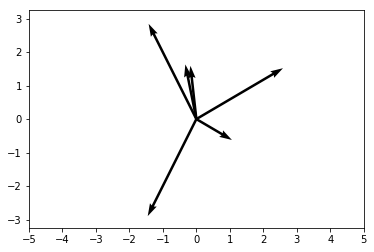

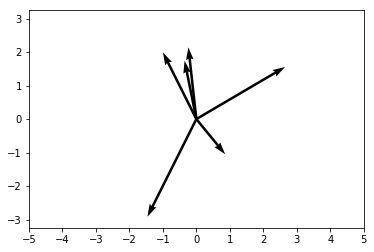

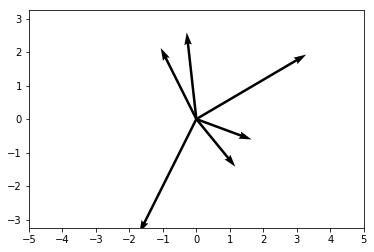

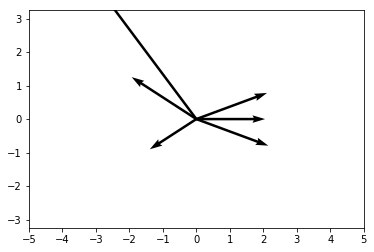

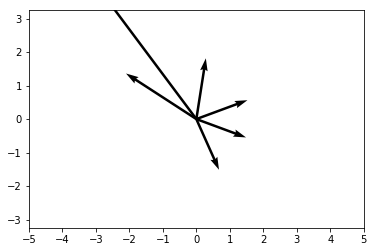

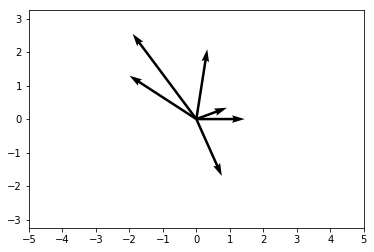

In [192]:
for hist, bins in r:
    plot_quiver(hist, bins, scale=0.2, n=6)